## **Executive Summary**

### **Key Findings**

In this notebook, I relied on a RandomForest model to determine my benchmark model. I utilized it to determine which features played the most significant role in inducing salary variance.


### **Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?**
- Country: Median salaries tended to be highest the countries of MX, PR, and US.
- Experience: Median salaries were highest for Executive, followed by Senior, Mid-level, and Entry-level
- Remote Ratio: Median Salaries were highest for pure on-site employees, whose salaries were only slightly higher than those of pure remote workers.

### **Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?**
Using the RandomForest model and only features pertaining to experience level, company location, and remote ratio revealed that the most important features that determined salary level was a company location in US or CA. A third feature, experience level, was of secondary significance.

### **Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions even more accurate future salary predictions even more accurate.**

After incorporating additional features of company size and employment type, the most influential features on data salaries were:
- job title containing word 'analyst'
- experience_level
- company location in US
- job title containing word 'data'
- remote_ratio

The insight that this information provides is that data salaries are strongly determined by position and location, specifically whether that location is the United States or not.

## 📖 **Background**
You work for an international HR consultancy helping companies attract and retain top talent in the competitive tech industry. As part of your services, you provide clients with insights into industry salary trends to ensure they remain competitive in hiring and compensation practices.

Your team wants to use a data-driven approach to analyse how various factors—such as job role, experience level, remote work, and company size—impact salaries globally. By understanding these trends, you can advise clients on offering competitive packages to attract the best talent.

In this competition, you’ll explore and visualise salary data from thousands of employees worldwide. f you're tackling the advanced level, you'll go a step further—building predictive models to uncover key salary drivers and providing insights on how to enhance future data collection.

## 💾 **Data**

The data comes from a survey hosted by an HR consultancy, available in `'salaries.csv'`.

#### Each row represents a single employee's salary record for a given year:
- **`work_year`** - The year the salary was paid.  
- **`experience_level`** - Employee experience level:  
  - **`EN`**: Entry-level / Junior  
  - **`MI`**: Mid-level / Intermediate  
  - **`SE`**: Senior / Expert  
  - **`EX`**: Executive / Director  
- **`employment_type`** - Employment type:  
  - **`PT`**: Part-time  
  - **`FT`**: Full-time  
  - **`CT`**: Contract  
  - **`FL`**: Freelance  
- **`job_title`** - The job title during the year.  
- **`salary`** - Gross salary paid (in local currency).  
- **`salary_currency`** - Salary currency (ISO 4217 code).  
- **`salary_in_usd`** - Salary converted to USD using average yearly FX rate.  
- **`employee_residence`** - Employee's primary country of residence (ISO 3166 code).  
- **`remote_ratio`** - Percentage of remote work:  
  - **`0`**: No remote work (<20%)  
  - **`50`**: Hybrid (50%)  
  - **`100`**: Fully remote (>80%)  
- **`company_location`** - Employer's main office location (ISO 3166 code).  
- **`company_size`** - Company size:  
  - **`S`**: Small (<50 employees)  
  - **`M`**: Medium (50–250 employees)  
  - **`L`**: Large (>250 employees)  

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Custom functions
import nb_helpers as nb

In [2]:
df = pd.read_csv('../data/salaries.csv')

df['job_title'] = df['job_title'].apply(lambda x: x.lower())
df['experience_level'] = df['experience_level'].apply(lambda x: x.lower())
df['employee_residence'] = df['employee_residence'].apply(lambda x: x.lower())
df['company_size'] = df['company_size'].apply(lambda x: x.lower())

df['company_location'] = nb.remap_company_location(df)

print(df.shape)

df.head()

(57194, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,mi,FT,developer,168276,USD,168276,us,0,US,m
1,2024,mi,FT,developer,112184,USD,112184,us,0,US,m
2,2024,en,FT,developer,180000,USD,180000,us,0,US,m
3,2024,en,FT,developer,133500,USD,133500,us,0,US,m
4,2024,en,FT,developer,122000,USD,122000,us,0,US,m


In [3]:
# useful containers
target = 'salary_in_usd'
salary_thereshold = df['salary_in_usd'].quantile(0.98)
models = []

## Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?

In [78]:
# Filter for Data Analysts, Data Scientists, and Machine Learning Engineers
roles_of_interest = ['data analyst', 'data scientist', 'machine learning engineer']
filtered_df = df[df['job_title'].isin(roles_of_interest)]


experience_map = {
    'se': 'senior',
    'mi': 'mid-level',
    'en': 'entry-level',
    'ex': 'executive'
}

# Task 1: Average salary by country, experience level, and remote ratio
salary_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].median().reset_index()
salary_by_country.columns = list(salary_by_country.columns[:1]) + ['median_salary']


count_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].count().reset_index()
count_by_country.columns = list(count_by_country.columns[:1]) + ['count_salary']

merge_cols = list(salary_by_country.columns[:1])

salary_df = pd.merge(salary_by_country, count_by_country, on = 'employee_residence').sort_values(by = "median_salary", ascending = False)
salary_threshold = salary_df['count_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_salary'] > salary_threshold].set_index('employee_residence')[['median_salary']]

<Figure size 1000x600 with 0 Axes>

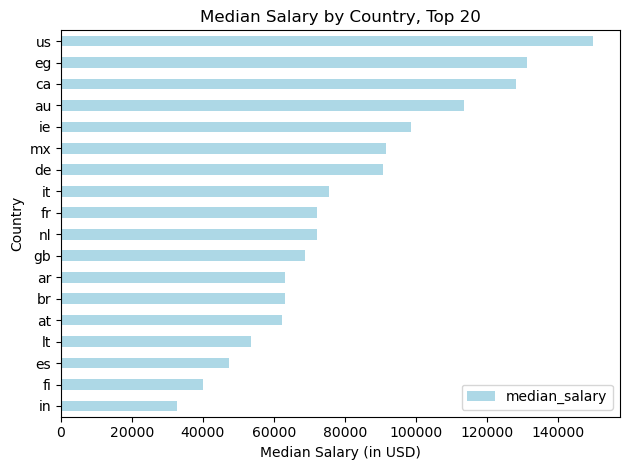

In [79]:
# Task 1: Visualize the results for salary impact analysis
top = 20

# Visualization for Salary by Country
plt.figure(figsize=(10, 6))
salary_df[:top][::-1].plot(kind='barh', color='lightblue')
plt.title(f'Median Salary by Country, Top {top}')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

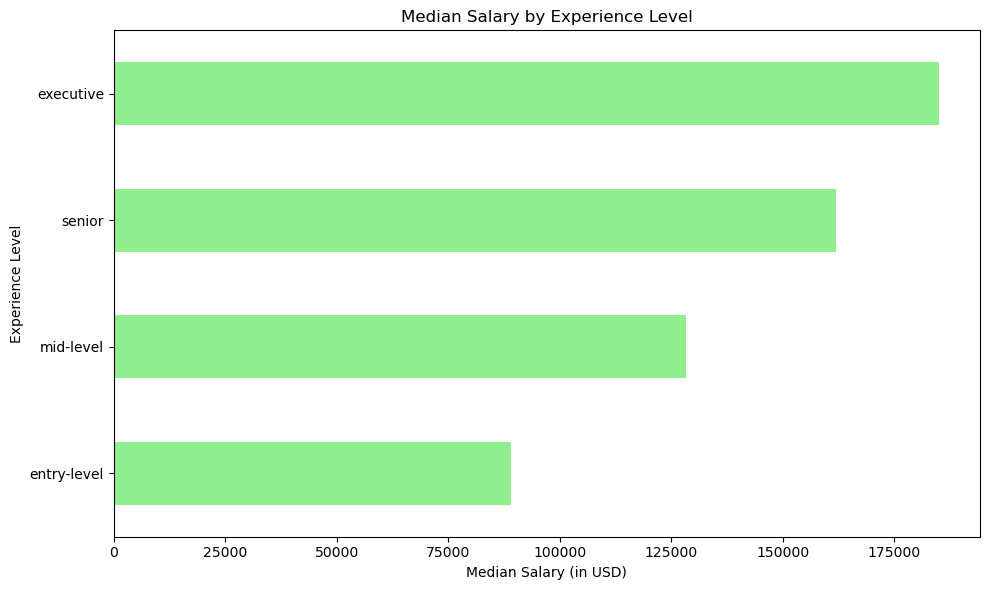

In [6]:
avg_salary_by_experience = filtered_df.groupby('experience_level')['salary_in_usd'].median().sort_values(ascending=False)
avg_salary_by_experience.index = [experience_map[role] for role in avg_salary_by_experience.index]

# Visualization for Average Salary by Experience Level
plt.figure(figsize=(10, 6))
avg_salary_by_experience[::-1].plot(kind='barh', color='lightgreen')
plt.title('Median Salary by Experience Level')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Experience Level')
plt.tight_layout()
plt.show()

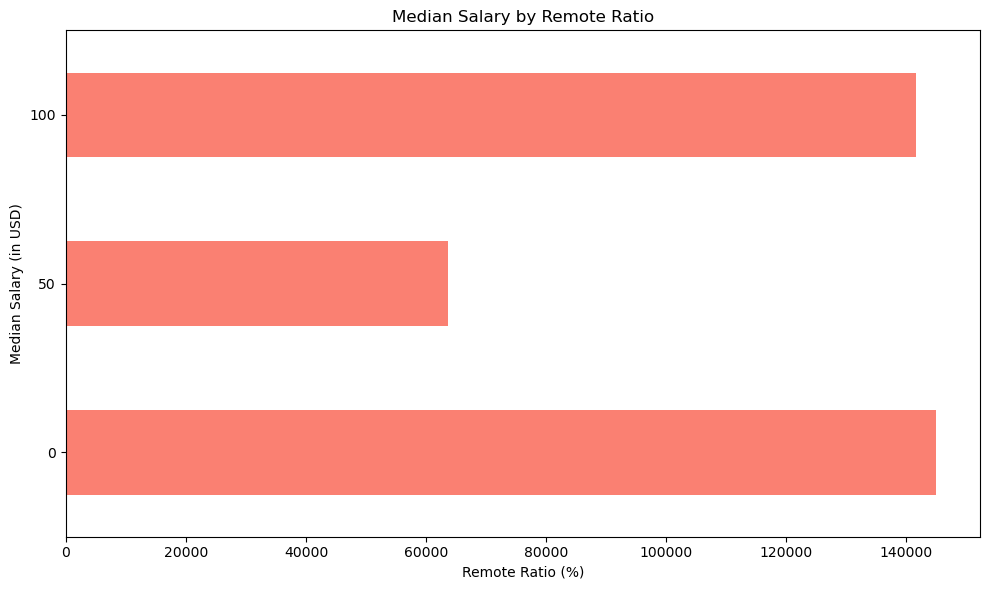

In [20]:
avg_salary_by_remote_ratio = filtered_df.groupby('remote_ratio')['salary_in_usd'].median()

# Visualization for Average Salary by Remote Ratio
plt.figure(figsize=(10, 6))
avg_salary_by_remote_ratio.plot(kind='barh', color='salmon')
plt.title('Median Salary by Remote Ratio')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Median Salary (in USD)')
plt.tight_layout()
plt.show()

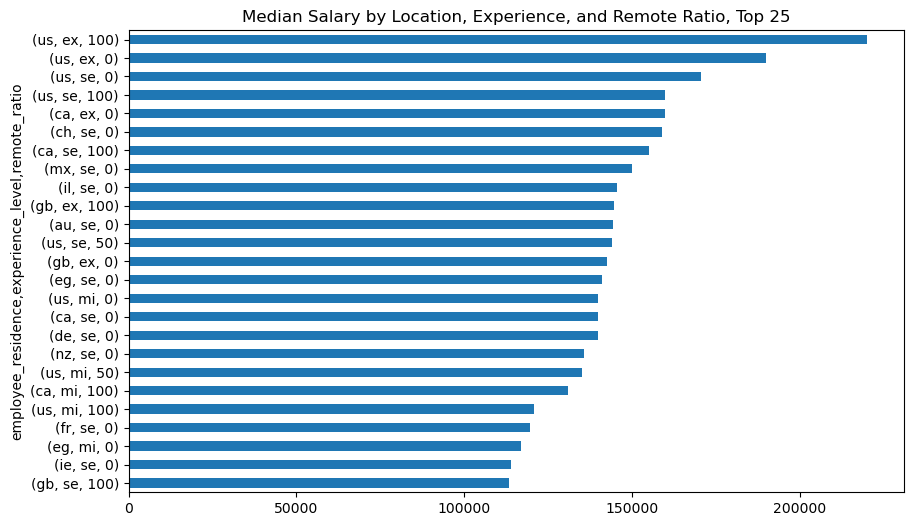

In [53]:
median_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].median().reset_index()
median_salaries.columns = list(median_salaries.columns[:3]) + ['median_salary']
count_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].count().reset_index()
count_salaries.columns = list(count_salaries.columns[:3]) + ['count_of_salary']

merge_cols = list(median_salaries.columns[:3])
salary_df = pd.merge(median_salaries, count_salaries, on = merge_cols).sort_values(by = 'median_salary', ascending = False)
salary_threshold = salary_df['count_of_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_of_salary'] > salary_threshold]
salary_df


top = 25
plt.figure(figsize=(10, 6))
salary_df.set_index(['employee_residence', 'experience_level', 'remote_ratio'])['median_salary'][:top][::-1].plot(kind = "barh")
plt.title(f'Median Salary by Location, Experience, and Remote Ratio, Top {top}')
plt.show()

## Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?

### Model 1: Baseline

In [9]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc']
df1 = nb.ohe_features_and_concat(df1, feature_list)

df1 = df1.drop(['work_year','salary_currency','salary','employee_residence','company_size', 'job', 'type'], axis = 1)

In [10]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_PL,company_loc_PT,company_loc_RU,company_loc_SE,company_loc_SG,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_US,company_loc_ZA
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


model 1 (baseline) RMSE score: 66109.99




<Figure size 1000x600 with 0 Axes>

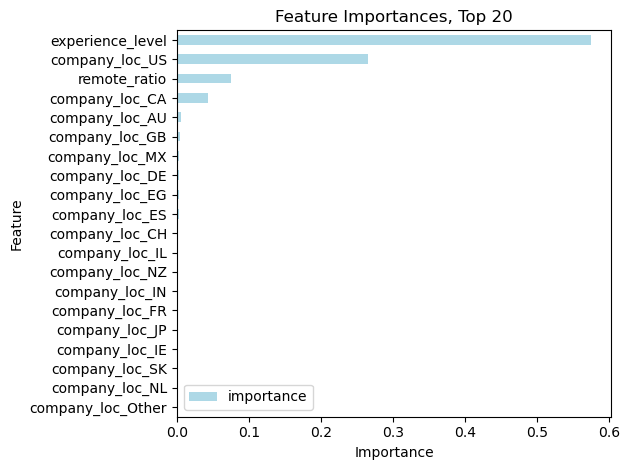

In [11]:
model_name = 'model 1 (baseline)'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

## Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? 

### Model 2: Adding company size and employment type

In [12]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc','company_size','type']
df1 = nb.ohe_features_and_concat(df1, feature_list)

# Drop columns
df1.drop(['salary','salary_currency','employee_residence', 'work_year', 'job'], axis = 1, inplace = True)

In [13]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_US,company_loc_ZA,company_size_m,company_size_s,type_FL,type_FT,type_PT
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


model 2 RMSE score: 66085.67




<Figure size 1000x600 with 0 Axes>

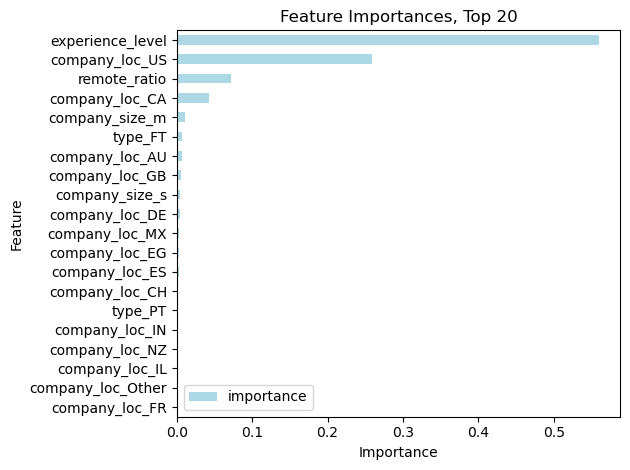

In [14]:
model_name = 'model 2'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

## Propose new features to make future salary predictions even more accurate future salary predictions even more accurate.

### Model 3: Add job title information

In [15]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc','company_size','type']
df1 = nb.ohe_features_and_concat(df1, feature_list)

# Job Title token
vectorizer = CountVectorizer(lowercase=True, binary=True, max_features = 50, )
job_title_counts = vectorizer.fit_transform(df1['job'])
columns = vectorizer.get_feature_names_out()
columns = [f'title_{c}' for c in columns]
job_title_counts_df = pd.DataFrame(job_title_counts.toarray(), columns=columns)
df1 = pd.concat([df1, job_title_counts_df], axis=1)

# Drop columns
df1.drop(['salary','salary_currency','employee_residence', 'work_year', 'job'], axis = 1, inplace = True)

In [16]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,title_researcher,title_scientist,title_site,title_software,title_solutions,title_specialist,title_stack,title_systems,title_vision,title_visualization
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


model 3 RMSE score: 60457.85




<Figure size 1000x600 with 0 Axes>

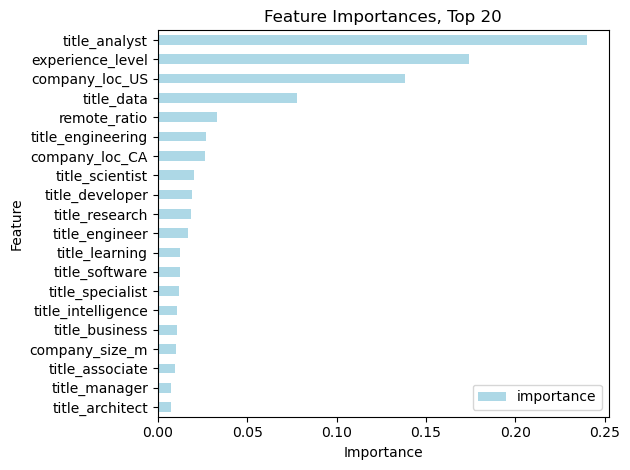

In [17]:
model_name = 'model 3'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

### Summary

In [18]:
model_df = pd.DataFrame(models).drop('model', axis = 1).sort_values(by='rmse')
best_model = model_df.iloc[0]
model_df

,name,n_features,rmse,best_features
2,model 3,98,60457.85,"[title_analyst, experience_level, company_loc_..."
1,model 2,48,66085.67,"[experience_level, company_loc_US, remote_ratio]"
0,model 1 (baseline),43,66109.99,"[experience_level, company_loc_US, remote_ratio]"


In [19]:
print(f"The best model is {best_model['name']}. It was trained on {best_model['n_features']} features and achieved a root mean squared error score of {best_model['rmse'].round(0)}. \n\nThe model's most influential features were: ")
for feature in best_model['best_features']:
    print(f"- {feature}")

The best model is model 3. It was trained on 98 features and achieved a root mean squared error score of 60458.0. 

The model's most influential features were: 
- title_analyst
- experience_level
- company_loc_US
- title_data
- remote_ratio
